In [1]:

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import norm
from IPython.display import display
from matplotlib.patches import Rectangle

from experiments.pw_exp import (
    TransitionType,
    NumGTModes,
    ExperimentConfig
)

from experiments.utils import mean_ci, median_ci


In [2]:


def plot_suite(df, metric_values, confidence_level=0.9):
    
    # Hue and line stype is initialization method
    # Marker style is number of learned modes
    # Plot number of demonstrations on X axis
    # Plot NID on y-axis
    # For each datapoint, plot mean and 90% confidence interval
    # Connect datapoints with linear lines
    
    
    
    possible_metric_values = [
        "Iterations",
        "Runtime",
        "NLL",
        "NID",
        "aNID",
        "MCFEVD",
        "MEVD"
        "MCFILE",
        "MILE"
    ]
    
    for metric_str in metric_values:
        assert metric_str in possible_metric_values
    
    df["Initialisation"] = df["Initialisation"].astype(str)
    init_method_values = sorted(list(set([s for s in df["Initialisation"] if s != 'nan'])), reverse=True)
    num_learned_modes_values = sorted(df["Num Learned Clusters"].unique().astype(int))
    num_rollouts_values = sorted(df["Num Rollouts"].unique())
    
    sns.set_context('poster')
    fig, axes = plt.subplots(
        len(num_learned_modes_values),
        len(metric_values),
        sharex=True,
        figsize=(7 * len(metric_values), 6 * len(num_learned_modes_values)),
        dpi=300,
        gridspec_kw=dict(wspace=0.15, hspace=0.1)
    )
    
    # Sweep different metrics (horizontal plot identity)
    for metric_idx, metric in enumerate(metric_values):
        
        # Sweep number learned modes (y plot location)
        for learned_modes_idx, num_learned_modes in enumerate(num_learned_modes_values):

            plt.sca(axes[learned_modes_idx][metric_idx])

            # Sweep initialization methods
            for init_idx, init_method in enumerate(init_method_values):
                color_str = f"C{init_idx}"
                line_style = ['-', '--', ':'][init_idx]
                legend_str = {
                    "uniform": 'Uniform',
                    "kmeans": 'K-Means',
                    "gmm": 'GMM',
                }[init_method]
                marker_style = ['o', '^', 'D'][init_idx]
                
                # Sweep number of rollouts (x-axis)
                x = []
                y = []
                yerr = []
                y_test = []
                yerr_test = []
                for num_rollouts in num_rollouts_values:
                    
                    # Slice this experiment
                    exp = df.query("""
                    `Initialisation` == @init_method &"""
                    """`Num Learned Clusters` == @num_learned_modes &"""
                    """`Num Rollouts` == @num_rollouts
                    """)
                    x.append(num_rollouts)
                    
                    # Print title for this plot? (only for first row)
                    if metric == "Iterations":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Iterations"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Iterations"
                        #_, ymax = plt.ylim()
                        #ymin = -1
                        #plt.ylim(ymin, ymax)
                        
                    elif metric == "Runtime":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Runtime (s)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        plt.semilogy()
                        
                        title_str = "$\log_{10}$ Runtime in seconds"
                        
                    elif metric == "NLL":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Negative Log Likelihood (Train Set)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp["Negative Log Likelihood (Test Set)"], confidence_level=confidence_level)
                        y_test.append(ybar_test)
                        yerr_test.append(yhigh_test - ybar_test)
                        
                        title_str = "Negative Log Likelihood"
                        
                    elif metric == "NID":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Normalized Information Distance (Train Set)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp["Normalized Information Distance (Test Set)"], confidence_level=confidence_level)
                        y_test.append(ybar_test)
                        yerr_test.append(yhigh_test - ybar_test)
                        
                        title_str = "Normalized Information Distance"
                        plt.ylim(-0.05, 1.05)
                        
                    elif metric == "aNID":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Adjusted Normalized Information Distance (Train Set)"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp["Adjusted Normalized Information Distance (Test Set)"], confidence_level=confidence_level)
                        y_test.append(ybar_test)
                        yerr_test.append(yhigh_test - ybar_test)
                        
                        title_str = "Normalized Information Distance\n(Adjusted for chance)"
                        plt.ylim(-0.05, 1.05)
                        
                    elif metric == "MCFILE":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Min Cost Flow ILE"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Min Cost Flow\nInverse Learning Error"
                        
                    elif metric == "MILE":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Mean ILE"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Mean Inverse Learning Error"
                        
                    elif metric == "MCFEVD":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Min Cost Flow EVD"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Min Cost Flow\nExpected Value Difference"
                        
                    elif metric == "MILE":
                        
                        ylow, ybar, yhigh = mean_ci(exp["Mean EVD"], confidence_level=confidence_level)
                        y.append(ybar)
                        yerr.append(yhigh - ybar)
                        
                        title_str = "Mean Expected Value Difference"
                        
                    else:
                        raise ValueError
                    
                    if learned_modes_idx == 0:
                        plt.title(title_str, pad=10)
                
                x = np.array(x)
                y = np.array(y)
                yerr = np.array(yerr)
                
                plt.plot(
                    x,
                    y,
                    color=color_str,
                    label=legend_str,
                    marker=marker_style
                )
                plt.fill_between(
                    x,
                    y - yerr,
                    y + yerr,
                    color=color_str,
                    alpha=0.2
                )
                
                if len(y_test) > 0:
                    # Plot testing curves as dashed lines
                    
                    y_test = np.array(y_test)
                    yerr_test = np.array(yerr_test)

                    plt.plot(
                        x,
                        y_test,
                        color=color_str,
                        label=f"{legend_str} (test)",
                        marker=marker_style,
                        linestyle='--'
                    )
                    plt.fill_between(
                        x,
                        y_test - yerr_test,
                        y_test + yerr_test,
                        color=color_str,
                        alpha=0.2,
                        linestyle='--'
                    )
                    
                
                plt.xticks(x)
                if learned_modes_idx == len(num_learned_modes_values) - 1:
                    plt.xlabel("Number of demonstrations")
                
                if metric_idx == 0:
                    row_label = f"{num_learned_modes} learned mode{'s' if num_learned_modes > 1 else ''}"
                    if num_learned_modes < exp["Num GT Clusters"].unique()[0]:
                        row_label += "\n(under-clustering)"
                    elif num_learned_modes > exp["Num GT Clusters"].unique()[0]:
                        row_label += "\n(over-clustering)"
                    else:
                        row_label += "\n(matches GT)"
                    plt.ylabel(row_label, labelpad=10)
            
            if num_learned_modes == exp["Num GT Clusters"].unique()[0]:
                # Weare on the row where learned num modes == true num modes
                
                # Plot the baseline as a red line
                
                x_baseline = []
                y_baseline = []
                y_err_baseline = []
                y_test_baseline = []
                y_test_err_baseline = []
                plot_baseline = False
                for num_rollouts in num_rollouts_values:
                    
                    # Slice this experiment
                    legend_str = algorithm = 'Baseline-MaxEnt'
                    exp_baseline = df.query("""
                    `Algorithm` == @algorithm &"""
                    """`Num Learned Clusters` == @num_learned_modes &"""
                    """`Num Rollouts` == @num_rollouts
                    """)
                    
                    x_baseline.append(num_rollouts)
                    
                    if metric == "NLL":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Negative Log Likelihood (Train Set)"], confidence_level=confidence_level)
                        y_baseline.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp_baseline["Negative Log Likelihood (Test Set)"], confidence_level=confidence_level)
                        y_test_baseline.append(ybar_test)
                        y_test_err_baseline.append(yhigh_test - ybar_test)
                        
                    elif metric == "NID":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Normalized Information Distance (Train Set)"], confidence_level=confidence_level)
                        y_baseline.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp_baseline["Normalized Information Distance (Test Set)"], confidence_level=confidence_level)
                        y_test_baseline.append(ybar_test)
                        y_test_err_baseline.append(yhigh_test - ybar_test)
                        
                    elif metric == "aNID":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Adjusted Normalized Information Distance (Train Set)"], confidence_level=confidence_level)
                        y_baseline.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                        
                        ylow_test, ybar_test, yhigh_test = mean_ci(exp_baseline["Adjusted Normalized Information Distance (Test Set)"], confidence_level=confidence_level)
                        y_test_baseline.append(ybar_test)
                        y_test_err_baseline.append(yhigh_test - ybar_test)
                        
                    elif metric == "MCFILE":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Min Cost Flow ILE"], confidence_level=confidence_level)
                        y_baseline.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                        
                    elif metric == "MILE":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Mean ILE"], confidence_level=confidence_level)
                        y.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                        
                    elif metric == "MCFEVD":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Min Cost Flow EVD"], confidence_level=confidence_level)
                        y_baseline.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                        
                    elif metric == "MILE":
                        plot_baseline = True
                        
                        ylow, ybar, yhigh = mean_ci(exp_baseline["Mean EVD"], confidence_level=confidence_level)
                        y_baseline.append(ybar)
                        y_err_baseline.append(yhigh - ybar)
                
                if plot_baseline:
                    x_baseline = np.array(x_baseline)
                    y_baseline = np.array(y_baseline)
                    y_err_baseline = np.array(y_err_baseline)
                    
                    plt.plot(
                        x_baseline,
                        y_baseline,
                        color='r',
                        label=legend_str,
                        marker='.'
                    )
                    plt.fill_between(
                        x_baseline,
                        y_baseline - y_err_baseline,
                        y_baseline + y_err_baseline,
                        color='r',
                        alpha=0.2
                    )

                    if len(y_test_baseline) > 0:
                        # Plot testing curves as dashed lines

                        y_test_baseline = np.array(y_test_baseline)
                        y_test_err_baseline = np.array(y_test_err_baseline)

                        plt.plot(
                            x,
                            y_test_baseline,
                            color='r',
                            label=f"{legend_str} (test)",
                            marker='.',
                            linestyle='--'
                        )
                        plt.fill_between(
                            x,
                            y_test_baseline - y_test_err_baseline,
                            y_test_baseline + y_test_err_baseline,
                            color='r',
                            alpha=0.2,
                            linestyle='--'
                        )
            
            plt.gca().yaxis.tick_right()
            plt.tick_params(axis='y', length=0)
    
    return fig, axes


In [8]:

# Load the experimental static inputs
config = ExperimentConfig(TransitionType.STOCHASTIC, NumGTModes.THREE)

# Load the experimental results
df_filename = f"CanonicalPuddleWorld-experiments-metrics.csv"
df = pd.read_csv(df_filename)

# Query for the experiment config we care about
df.query("""
`Transition Type` == @config.transition_type.value and\
`Num GT Clusters` == @config.num_gt_modes.value\
""", inplace=True)

confidence_level = 0.90

sns.set()
fig, axes = plot_suite(df, ["Iterations", "NLL", "MCFEVD", "aNID"], confidence_level=confidence_level)

# Make y-limits for each column of plots consistent
for column in range(len(axes[0])):
    
    ymin = np.inf
    ymax = -np.inf
    
    for row in range(len(axes)):
        ax = axes[row][column]
        _ymin, _ymax = ax.get_ylim()
        ymin = min(ymin, _ymin)
        ymax = max(ymax, _ymax)
    
    for row in range(len(axes)):
        ax = axes[row][column]
        ax.set_ylim(ymin, ymax)

# Adjust ylimits for certain columns
for ax_row in axes:
    if config.transition_type == TransitionType.STOCHASTIC and config.num_gt_modes == NumGTModes.THREE:
        ymin, ymax = ax_row[0].get_ylim()
        ax_row[0].set_ylim(-5, ymax)
        
        ymin, ymax = ax_row[2].get_ylim()
        ax_row[2].set_ylim(ymin, 10.3)
        
    if config.transition_type == TransitionType.STOCHASTIC and config.num_gt_modes == NumGTModes.TWO:
        ymin, ymax = ax_row[0].get_ylim()
        ax_row[0].set_ylim(-5, ymax)
        
    if config.transition_type == TransitionType.DETERMINISTIC and config.num_gt_modes == NumGTModes.THREE:        
        ymin, ymax = ax_row[2].get_ylim()
        ax_row[2].set_ylim(-5, ymax)
        
    if config.transition_type == TransitionType.DETERMINISTIC and config.num_gt_modes == NumGTModes.TWO:        
        ymin, ymax = ax_row[2].get_ylim()
        ax_row[2].set_ylim(-10, ymax)

# Produce legend, in a particular order
handles, labels = plt.gca().get_legend_handles_labels()
legend_axes_pad = 3 if (config.num_gt_modes == NumGTModes.THREE) else 1
order = [0, 2, 4, 1, 3, 5]
fig.legend(
    [handles[idx] for idx in order],
    [labels[idx] for idx in order],
    ncol=6,
    loc='lower center',
    borderaxespad=legend_axes_pad
)

# Add title
mode_names = "/".join([s.capitalize() for s in NumGTModes.get_mode_names(config.num_gt_modes)])
plt.suptitle(
    f"{mode_names} {config.transition_type.value.capitalize()} PuddleWorld - Means and ± {int(confidence_level * 100)}% CIs",
    y=0.93 if config.num_gt_modes == NumGTModes.THREE else 0.95
)

# Highlight the middle row where learned number of modes == GT number of modes
rect_pad = 0.03
if config.num_gt_modes == NumGTModes.TWO:
    rect = Rectangle(
        (
            0.085,
            1.0 / 3.0 + rect_pad * 1.2
        ),
        0.85,
        1.0 / 3.0 - rect_pad * 2.4,
        linewidth=0,
        facecolor='r',
        alpha=0.1,
        zorder=-1
    )
else:
    rect = Rectangle(
        (
            0.085,
            2.0 / 5.0 + rect_pad * 0.85
        ),
        0.85,
        1.0 / 5.0 - rect_pad * 1.5,
        linewidth=0,
        facecolor='r',
        alpha=0.1,
        zorder=-1
    )
fig.add_artist(rect)


fig_filename = f"CanonicalPuddleWorld-{config.transition_type.value}-{config.num_gt_modes.value}mode.pdf"
plt.savefig(fig_filename, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()


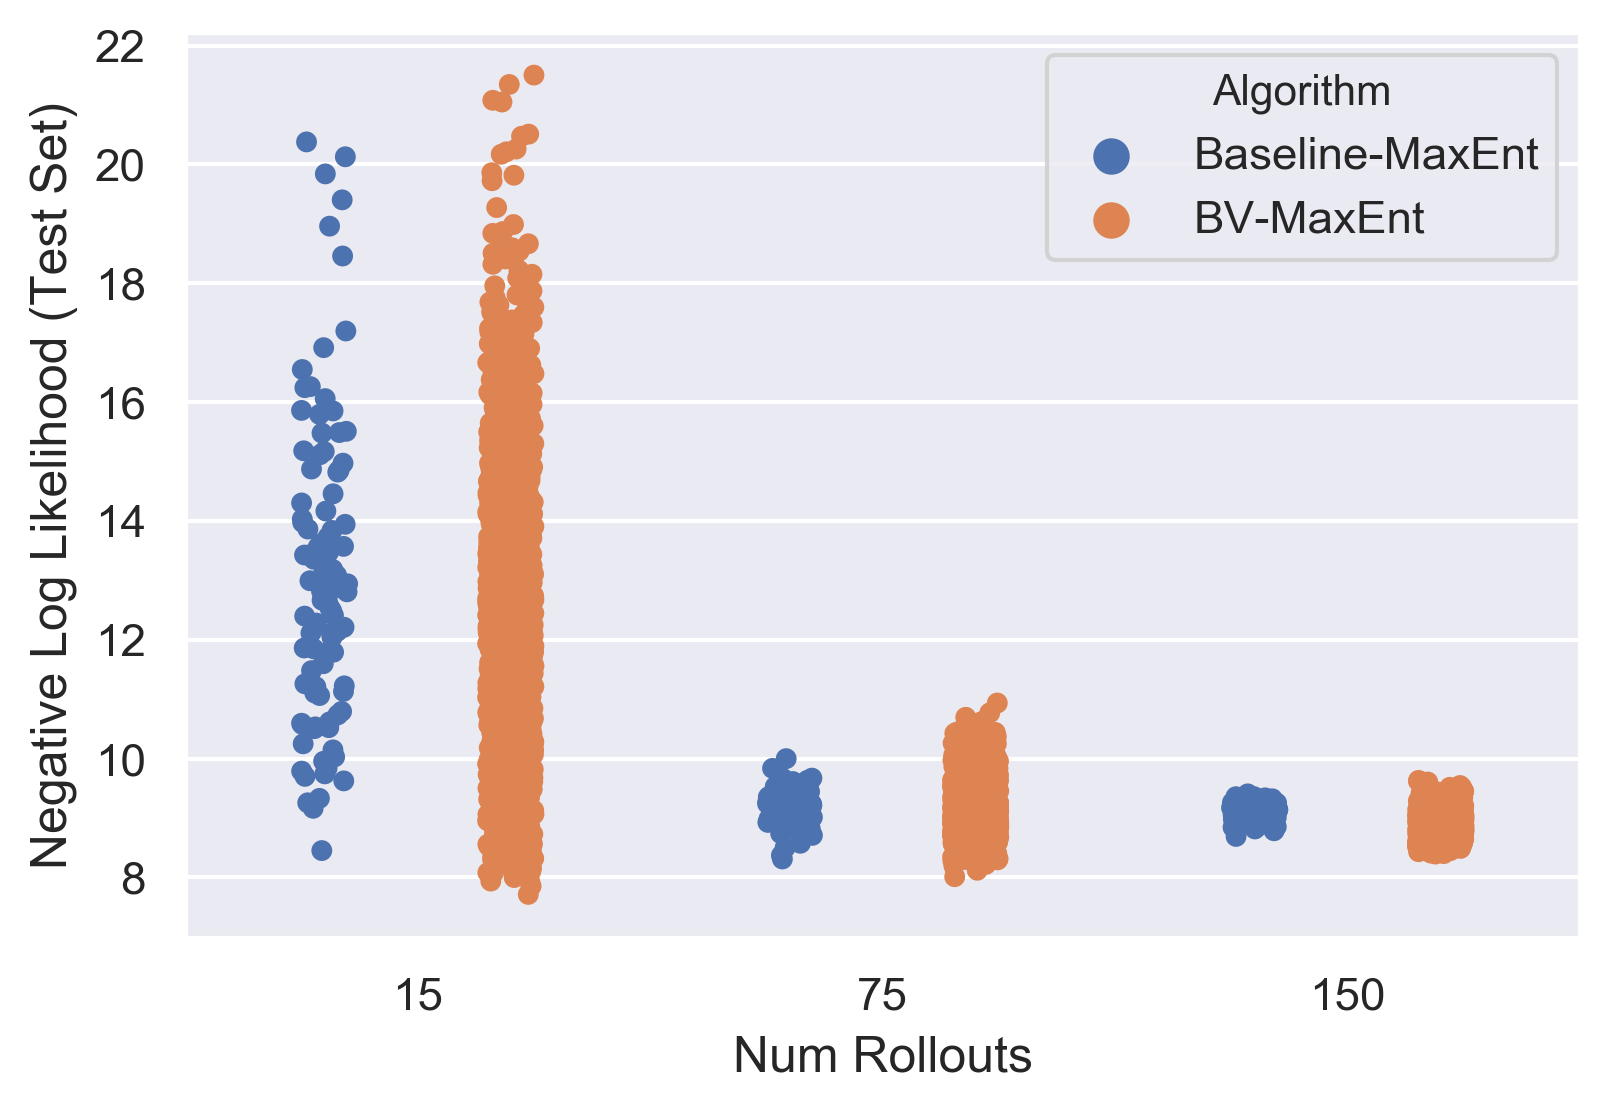

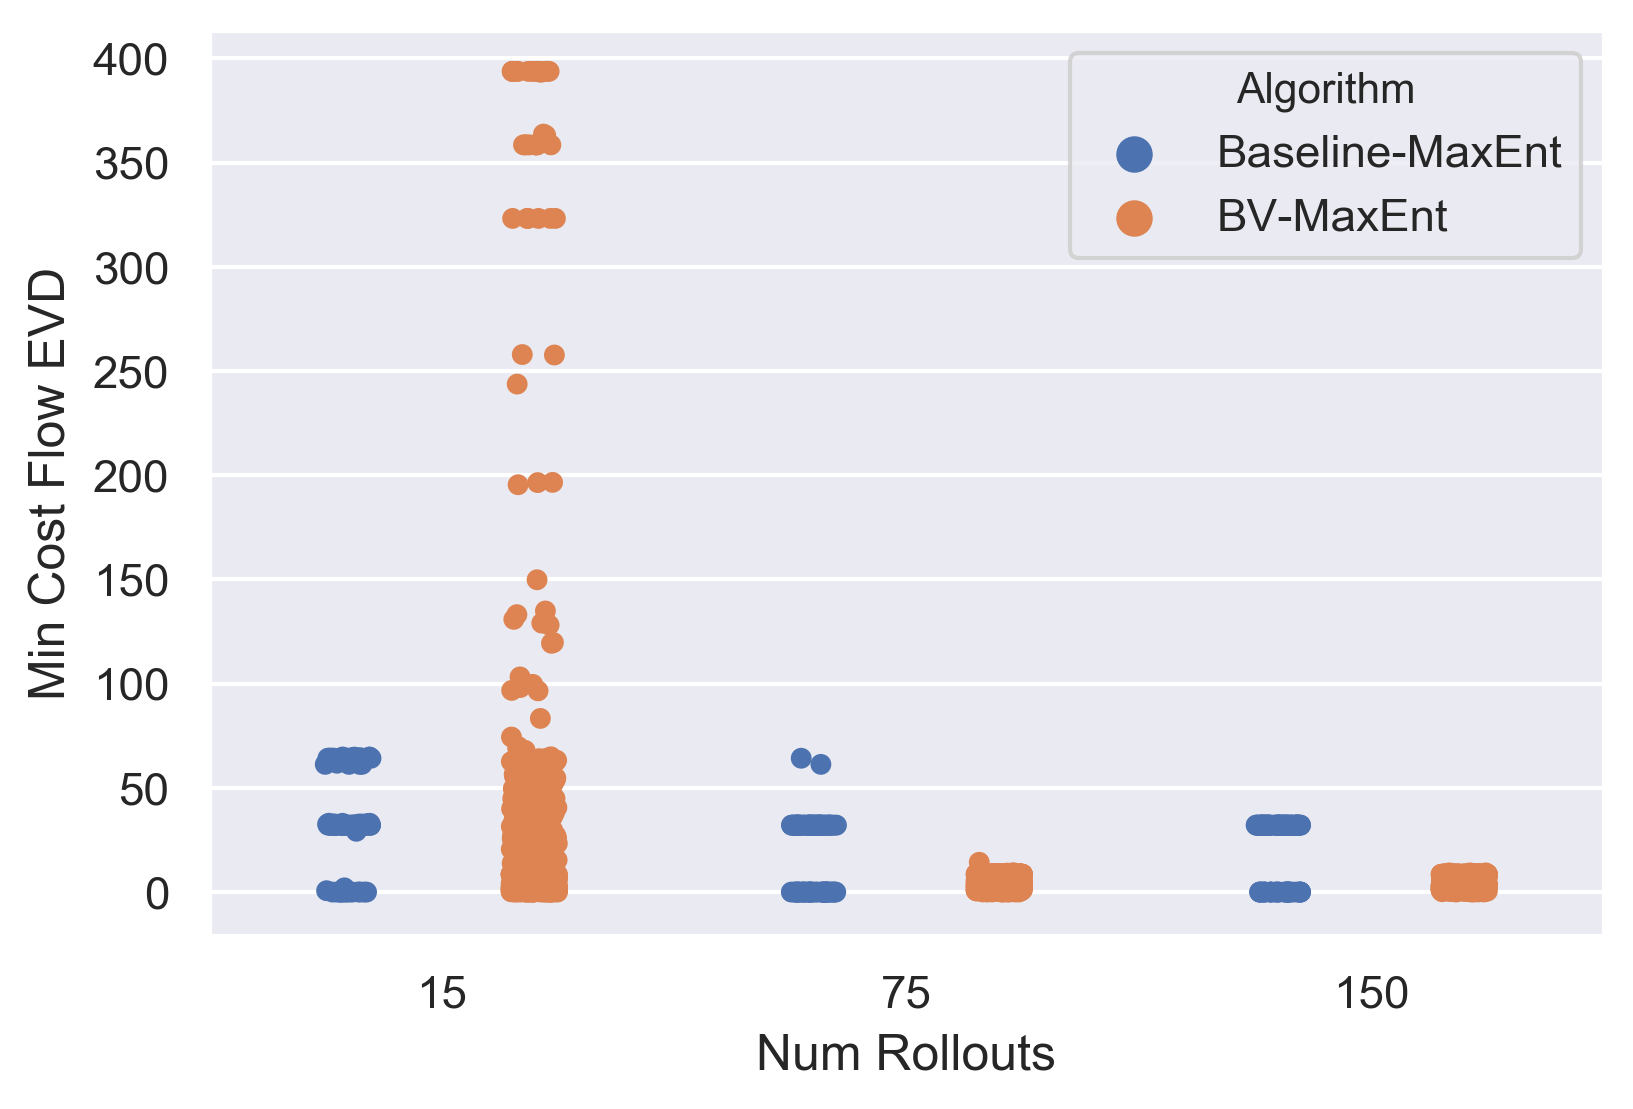

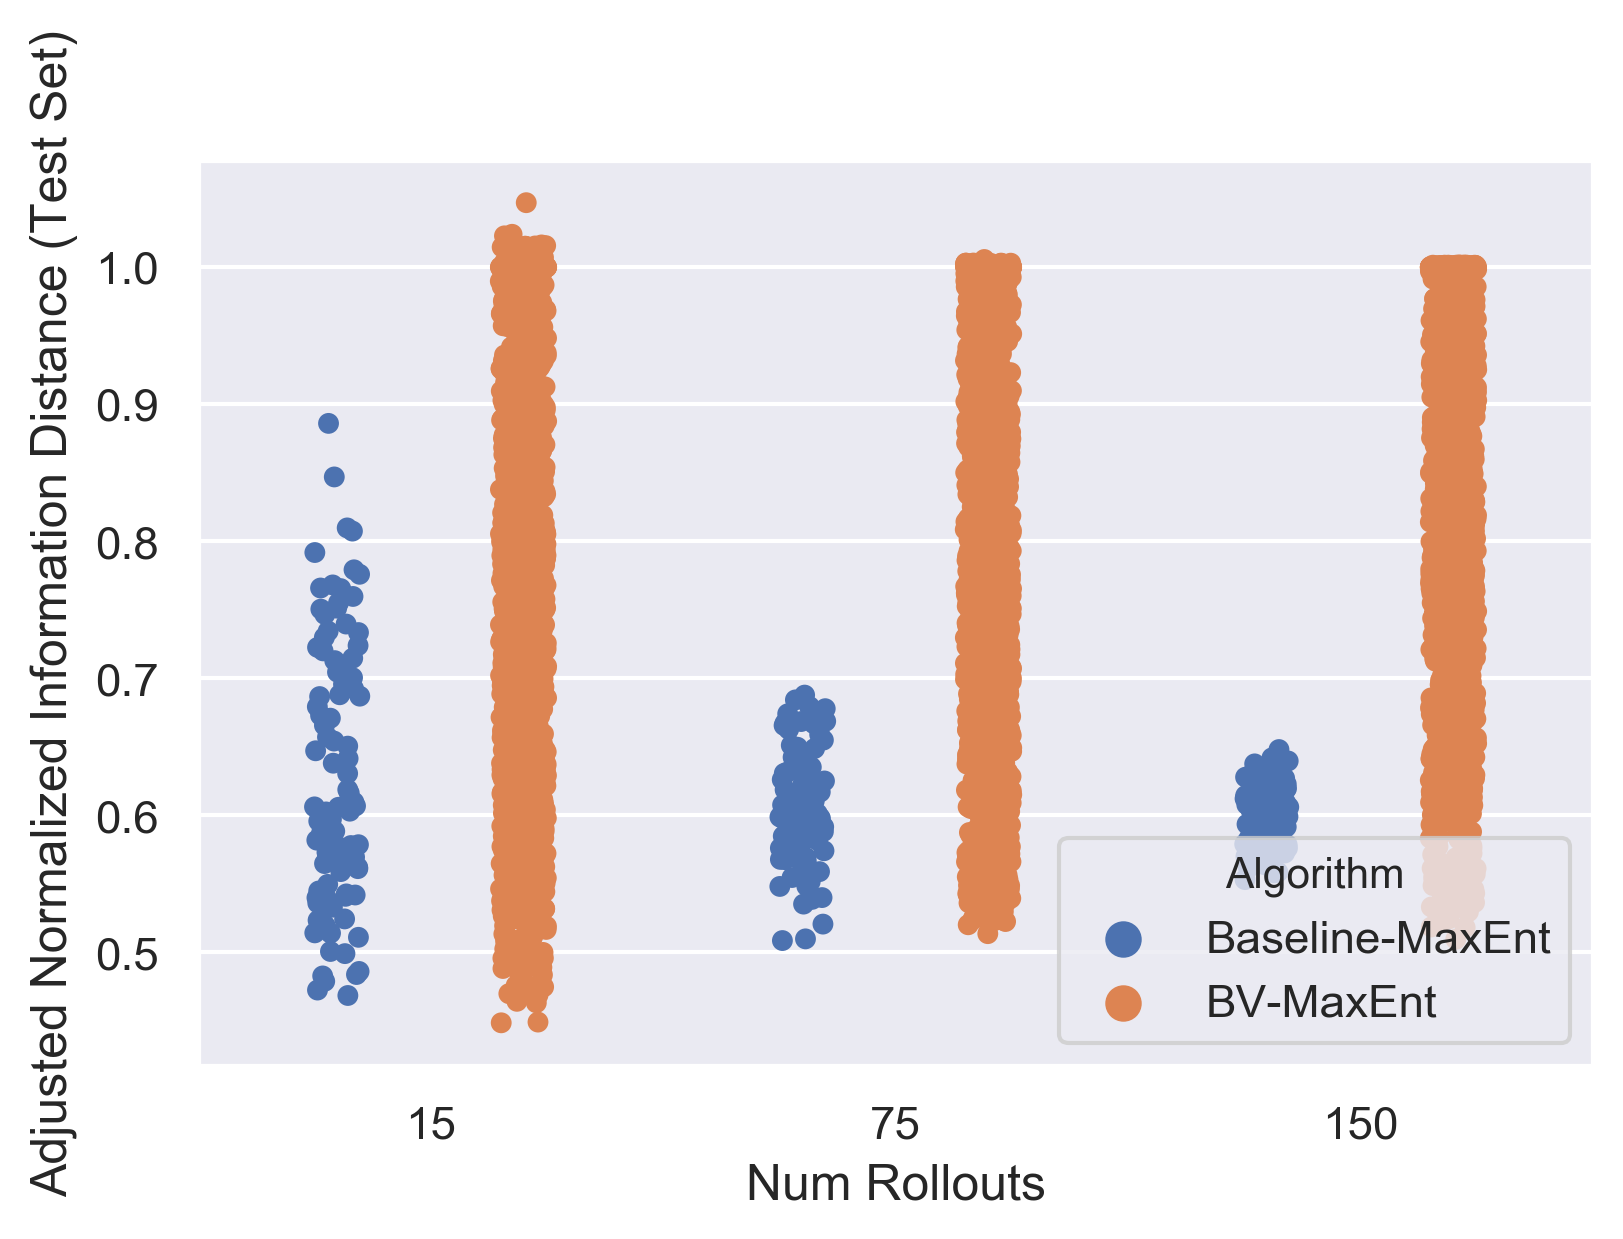

In [4]:

sns.set()

plt.figure(dpi=300)
sns.stripplot(
    #data=df[df['Algorithm'] == 'Baseline-MaxEnt'],
    data=df,
    x='Num Rollouts',
    y='Negative Log Likelihood (Test Set)',
    hue='Algorithm',
    dodge=True
)
plt.show()
plt.close()

plt.figure(dpi=300)
sns.stripplot(
    #data=df[df['Algorithm'] == 'Baseline-MaxEnt'],
    data=df,
    x='Num Rollouts',
    y='Min Cost Flow EVD',
    hue='Algorithm',
    dodge=True
)
plt.show()
plt.close()

plt.figure(dpi=300)
sns.stripplot(
    #data=df[df['Algorithm'] == 'Baseline-MaxEnt'],
    data=df,
    x='Num Rollouts',
    y='Adjusted Normalized Information Distance (Test Set)',
    hue='Algorithm',
    dodge=True
)
plt.show()
plt.close()


In [12]:


# Query for the experiment config we care about
df = pd.read_csv("CanonicalPuddleWorld-experiments-metrics.csv")
config = ExperimentConfig(TransitionType.DETERMINISTIC, NumGTModes.TWO)
df.query("""
Algorithm == 'Baseline-MaxEnt' and\
`Num Rollouts` == 100 and\
`Transition Type` == @config.transition_type.value and\
`Num GT Clusters` == @config.num_gt_modes.value\
""", inplace=True)

df


Environment Transition Type  Num GT Clusters  \
200  CanonicalPuddleWorld   deterministic                2   
201  CanonicalPuddleWorld   deterministic                2   
202  CanonicalPuddleWorld   deterministic                2   
203  CanonicalPuddleWorld   deterministic                2   
204  CanonicalPuddleWorld   deterministic                2   
..                    ...             ...              ...   
295  CanonicalPuddleWorld   deterministic                2   
296  CanonicalPuddleWorld   deterministic                2   
297  CanonicalPuddleWorld   deterministic                2   
298  CanonicalPuddleWorld   deterministic                2   
299  CanonicalPuddleWorld   deterministic                2   

     Num Learned Clusters  Num Rollouts        Algorithm Initialisation  \
200                     2           100  Baseline-MaxEnt            NaN   
201                     2           100  Baseline-MaxEnt            NaN   
202                     2           100  Baseline-MaxEnt            NaN   
203                     2           100  Baseline-MaxEnt            NaN   
204                     2           100  Baseline-MaxEnt            NaN   
..                    ...           ...              ...            ...   
295                     2           100  Baseline-MaxEnt            NaN   
296                     2           100  Baseline-MaxEnt            NaN   
297                     2           100  Baseline-MaxEnt            NaN   
298                     2           100  Baseline-MaxEnt            NaN   
299                     2           100  Baseline-MaxEnt            NaN   

     Replicate  Iterations                              Responsibility Matrix  \
200          0         NaN  [[0.9999999999253826, 7.461741711270133e-11], ...   
201          1         NaN  [[0.9999999999424303, 5.7569785743047245e-11],...   
202          2         NaN  [[0.9999999999648557, 3.51443564845313e-11], [...   
203          3         NaN  [[0.9999999998785815, 1.2141848792161702e-10],...   
204          4         NaN  [[0.9999999998228003, 1.7719978444501508e-10],...   
..         ...         ...                                                ...   
295         95         NaN  [[0.9999999999490562, 5.0943773359107494e-11],...   
296         96         NaN  [[0.9999999998734763, 1.265236991022134e-10], ...   
297         97         NaN  [[0.9999999998543725, 1.4562752131724897e-10],...   
298         98         NaN  [[0.9999999999173245, 8.267542500690607e-11], ...   
299         99         NaN  [[0.999999999843646, 1.563540610606592e-10], [...   

                                        Reward Weights  Runtime (s)  \
200  [[-2.093272012713498, -2.2716736641551116, -1....          NaN   
201  [[-1.9718840329220109, -1.6024320644100685, -2...          NaN   
202  [[-2.0502323880296847, -2.2128776974387794, -1...          NaN   
203  [[-2.2744451118568514, -1.7953813652697088, -2...          NaN   
204  [[-1.7505416402775535, -1.3480487730759507, -1...          NaN   
..                                                 ...          ...   
295  [[-1.7364186200589093, -2.158482922087955, -1....          NaN   
296  [[-2.2366590584134096, -1.9810128016818405, -1...          NaN   
297  [[-2.1016645356237404, -1.4796321275663757, -1...          NaN   
298  [[-2.018399787167287, -2.0256119416350993, -1....          NaN   
299  [[-2.198809746964393, -1.4350161315637824, -1....          NaN   

     Negative Log Likelihood (Test Set)  Negative Log Likelihood (Train Set)  \
200                            9.124156                             8.710039   
201                            9.176721                             8.973054   
202                            9.067666                             9.068759   
203                            8.837567                             8.952824   
204                            9.045635                             9.174147   
..                                  ...                       

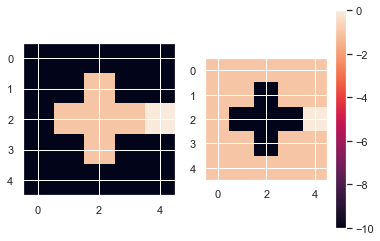

In [36]:

from puddle_world.envs import CanonicalPuddleWorldEnv


sns.set()

env = CanonicalPuddleWorldEnv(mode='wet')
fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.imshow(
    env.state_rewards.reshape(5, 5)
)

plt.sca(ax2)
env = CanonicalPuddleWorldEnv(mode='dry')
plt.imshow(
    env.state_rewards.reshape(5, 5)
)
plt.colorbar()
plt.show()
plt.close()


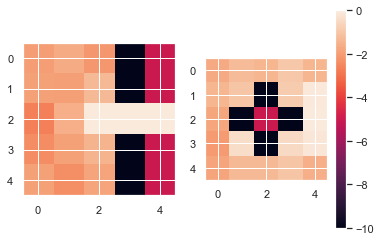

In [37]:

rewards = np.array(eval(df[df["Min Cost Flow EVD"] < 1.0].iloc[0]["Reward Weights"]))

sns.set()

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.imshow(
    rewards[0, :].reshape(5, 5)
)

plt.sca(ax2)
plt.imshow(
    rewards[1, :].reshape(5, 5)
)
plt.colorbar()

plt.show()
plt.close()


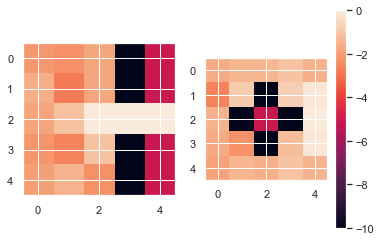

In [38]:

rewards = np.array(eval(df[df["Min Cost Flow EVD"] > 40.0].iloc[0]["Reward Weights"]))

sns.set()

fig, (ax1, ax2) = plt.subplots(1, 2)
plt.sca(ax1)
plt.imshow(
    rewards[0, :].reshape(5, 5)
)

plt.sca(ax2)
plt.imshow(
    rewards[1, :].reshape(5, 5)
)

plt.colorbar()
plt.show()
plt.close()
